# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_175  P68104;Q5VTE0    13.165
Sample_134  P14618-2         20.239
Sample_023  B4DPQ0           20.681
Sample_112  O43291           18.899
Sample_013  P26447           14.374
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups            
Sample_160  A0A0J9YW36;Q9NZ72;Q9NZ72-2   13.592
Sample_174  P35968;P35968-2;P35968-3     15.499
Sample_048  P01344;P01344-2;P01344-3     17.583
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.419
            A0A075B6Q5                 12.416
            A0A075B6R2                 12.830
            A0A075B6S5                 13.009
            A0A087WSY4                 11.710
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.446
            Q9UI40;Q9UI40-2            11.422
            Q9UIW2                     12.220
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.967
            Q9UP79                     12.278
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.878,15.050,16.842,19.863,15.942,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.774,19.067,...,15.528,15.576,13.899,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.818,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.147,17.705,17.039,15.457,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.919,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.399,15.345,17.084,18.708,14.249,19.433,11.619,10.603
Sample_207,15.739,16.877,15.469,16.898,13.917,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.267,12.437,13.963,12.460,13.125,13.441,12.425,12.463,12.821,14.026
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.280,19.067,16.127,...,12.602,11.579,12.907,11.850,12.708,12.642,12.624,12.914,14.229,11.043
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.327,13.460,12.127,12.063,11.536,11.141,12.823,12.473,14.358,13.157
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.955,12.663,13.520,13.738,12.325,12.147,12.937,12.004,13.154,12.700
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.033,12.946,12.718,12.954,13.269,13.764,12.777,13.019,13.236,13.580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,10.772,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 342.64it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.01it/s]

100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.81it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.20it/s]

100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.40it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.42it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.86it/s]

100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

100%|██████████| 5/5 [00:01<00:00,  4.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.70it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.16it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.14it/s]

100%|██████████| 6/6 [00:01<00:00,  4.16it/s]

100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.57it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.50it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.84it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.35it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.10it/s]

100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.54it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.29it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.39it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.22it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.12it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.87it/s]

100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

100%|██████████| 8/8 [00:01<00:00,  4.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.11it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.36it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.65it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.18it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.00it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.00it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.66it/s]

100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

100%|██████████| 9/9 [00:02<00:00,  4.15it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.15it/s]

 30%|███       | 3/10 [00:00<00:01,  4.73it/s]

 40%|████      | 4/10 [00:00<00:01,  4.65it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.23it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.22it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.00it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.89it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]

100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.21it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.48it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.42it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.95it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.42it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.09it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.96it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.69it/s]

100%|██████████| 11/11 [00:02<00:00,  3.62it/s]

100%|██████████| 11/11 [00:02<00:00,  4.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.72it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.45it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.59it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.15it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.15it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.06it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.08it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.15it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.26it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.19it/s]

100%|██████████| 12/12 [00:02<00:00,  4.01it/s]

100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.98it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.43it/s]

 31%|███       | 4/13 [00:00<00:01,  4.63it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.60it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.18it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.27it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.18it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.95it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.81it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.71it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.77it/s]

100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

100%|██████████| 13/13 [00:04<00:00,  3.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.45it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.71it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.39it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.19it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.30it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.44it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.56it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.70it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.80it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.84it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.83it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.74it/s]

100%|██████████| 14/14 [00:03<00:00,  3.78it/s]

100%|██████████| 14/14 [00:03<00:00,  3.68it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.01it/s]

 20%|██        | 3/15 [00:00<00:03,  3.95it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.91it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.79it/s]

 40%|████      | 6/15 [00:01<00:02,  3.82it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.72it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.60it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.24it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.01it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.81it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.84it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.75it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.87it/s]

100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

100%|██████████| 15/15 [00:04<00:00,  3.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.035 0.007          0.555 0.447       0.068   
2             0.003 0.001      0.041 0.015          0.696 0.116       0.509   
3             0.003 0.000      0.039 0.012          0.710 0.120       0.613   
4             0.003 0.001      0.037 0.012          0.712 0.115       0.613   
5             0.003 0.000      0.036 0.004          0.703 0.095       0.651   
6             0.003 0.000      0.040 0.012          0.785 0.082       0.790   
7             0.004 0.002      0.037 0.006          0.782 0.082       0.789   
8             0.003 0.000      0.037 0.007          0.780 0.083       0.778   
9             0.003 0.000      0.036 0.006          0.778 0.085       0.782   
10            0.003 0.000      0.032 0.004          0.774 0.085       0.783   
11            0.003 0.000      0.032 0.002          0.790 0.088       0.795   
12            0.003 0.000      0.032 0.003          0.790 0.089       0.799   
13            0.005 0.005      0.042 0.013          0.792 0.088       0.794   
14            0.004 0.003      0.047 0.016          0.796 0.088       0.783   
15            0.004 0.002      0.038 0.010          0.788 0.087       0.783   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.071   0.117 0.113                  0.528 0.032        0.842   
2          0.107   0.579 0.084                  0.669 0.058        0.713   
3          0.131   0.647 0.094                  0.709 0.072        0.780   
4          0.107   0.652 0.086                  0.712 0.067        0.798   
5          0.116   0.670 0.082                  0.723 0.067        0.798   
6          0.111   0.783 0.074                  0.815 0.061        0.885   
7          0.106   0.781 0.070                  0.813 0.058        0.884   
8          0.105   0.774 0.069                  0.807 0.057        0.884   
9          0.112   0.775 0.077                  0.808 0.063        0.882   
10         0.109   0.773 0.074                  0.806 0.062        0.885   
11         0.105   0.788 0.075                  0.819 0.063        0.893   
12         0.101   0.790 0.073                  0.820 0.063        0.895   
13         0.102   0.788 0.074                  0.819 0.063        0.894   
14         0.100   0.784 0.070                  0.816 0.059        0.900   
15         0.096   0.781 0.070                  0.813 0.059        0.898   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.819 0.089        210.000 0.000  
2          0.083                  0.669 0.099        210.000 0.000  
3          0.079                  0.715 0.097        210.000 0.000  
4          0.072                  0.762 0.093        210.000 0.000  
5          0.068                  0.754 0.092        210.000 0.000  
6          0.053                  0.855 0.063        210.000 0.000  
7          0.053                  0.853 0.064        210.000 0.000  
8          0.054                  0.852 0.067        210.000 0.000  
9          0.055                  0.853 0.064        210.000 0.000  
10         0.055                  0.859 0.064        210.000 0.000  
11         0.054                  0.871 0.061        210.000 0.000  
12         0.056                  0.878 0.058        210.000 0.000  
13         0.055                  0.875 0.059        210.000 0.000  
14         0.054                  0.885 0.057        210.000 0.000  
15         0.054                  0.883 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 546.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.40it/s]

100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.13it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.04it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.03it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.32it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.70it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:02<00:00,  3.01it/s]

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.72it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.34it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.71it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.60it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.79it/s]

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.23it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.18it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.98it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.81it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.83it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.84it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.01it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.07it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.86it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.90it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.80it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.80it/s]

100%|██████████| 9/9 [00:03<00:00,  2.90it/s]

100%|██████████| 9/9 [00:03<00:00,  2.94it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.06it/s]

 30%|███       | 3/10 [00:00<00:02,  3.01it/s]

 40%|████      | 4/10 [00:01<00:02,  2.92it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.83it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.70it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.71it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.74it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.44it/s]

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.66it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.26it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.19it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.19it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.05it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.98it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.97it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.88it/s]

100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

100%|██████████| 11/11 [00:03<00:00,  3.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.02it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.39it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.93it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.63it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.57it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.60it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.54it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.51it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.59it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.59it/s]

100%|██████████| 12/12 [00:04<00:00,  2.49it/s]

100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.29it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.18it/s]

 31%|███       | 4/13 [00:01<00:02,  3.05it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.15it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.13it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.18it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.09it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.06it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.07it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.12it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.12it/s]

100%|██████████| 13/13 [00:04<00:00,  3.10it/s]

100%|██████████| 13/13 [00:04<00:00,  3.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.91it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.32it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.71it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.52it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.94it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.61it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.41it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.42it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.29it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.32it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.33it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.50it/s]

100%|██████████| 14/14 [00:05<00:00,  2.68it/s]

100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.83it/s]

 20%|██        | 3/15 [00:00<00:03,  3.86it/s]

 27%|██▋       | 4/15 [00:01<00:02,  3.74it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.55it/s]

 40%|████      | 6/15 [00:01<00:02,  3.31it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.26it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.24it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.26it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.28it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.20it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.24it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.14it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.87it/s]

100%|██████████| 15/15 [00:04<00:00,  2.54it/s]

100%|██████████| 15/15 [00:04<00:00,  3.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.044 0.020          0.118 0.288       0.013   
2             0.006 0.006      0.054 0.026          0.618 0.192       0.280   
3             0.004 0.004      0.048 0.016          0.757 0.096       0.742   
4             0.004 0.003      0.051 0.018          0.755 0.095       0.742   
5             0.004 0.002      0.042 0.013          0.737 0.082       0.705   
6             0.004 0.003      0.045 0.019          0.781 0.087       0.723   
7             0.004 0.000      0.042 0.014          0.836 0.088       0.787   
8             0.004 0.000      0.036 0.003          0.838 0.089       0.785   
9             0.003 0.000      0.038 0.011          0.841 0.089       0.785   
10            0.003 0.000      0.036 0.012          0.824 0.087       0.797   
11            0.004 0.002      0.037 0.010          0.823 0.083       0.801   
12            0.004 0.002      0.039 0.008          0.851 0.070       0.815   
13            0.006 0.005      0.053 0.020          0.845 0.070       0.800   
14            0.005 0.004      0.042 0.014          0.836 0.077       0.815   
15            0.005 0.003      0.053 0.025          0.838 0.078       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.023 0.058                  0.502 0.015        0.869   
2          0.117   0.366 0.117                  0.570 0.045        0.705   
3          0.120   0.742 0.081                  0.780 0.065        0.855   
4          0.124   0.741 0.085                  0.780 0.068        0.852   
5          0.109   0.715 0.077                  0.759 0.058        0.835   
6          0.101   0.747 0.076                  0.786 0.059        0.861   
7          0.100   0.807 0.073                  0.835 0.060        0.915   
8          0.092   0.807 0.071                  0.835 0.059        0.914   
9          0.091   0.808 0.067                  0.836 0.056        0.912   
10         0.094   0.805 0.066                  0.834 0.056        0.925   
11         0.092   0.808 0.065                  0.836 0.056        0.924   
12         0.096   0.828 0.060                  0.854 0.051        0.931   
13         0.090   0.818 0.054                  0.845 0.045        0.934   
14         0.083   0.822 0.057                  0.847 0.048        0.933   
15         0.092   0.819 0.059                  0.846 0.050        0.933   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.835 0.086        210.000 0.000  
2          0.093                  0.609 0.112        210.000 0.000  
3          0.053                  0.850 0.052        210.000 0.000  
4          0.055                  0.845 0.054        210.000 0.000  
5          0.053                  0.837 0.052        210.000 0.000  
6          0.056                  0.856 0.056        210.000 0.000  
7          0.045                  0.902 0.048        210.000 0.000  
8          0.047                  0.900 0.051        210.000 0.000  
9          0.047                  0.898 0.052        210.000 0.000  
10         0.043                  0.906 0.048        210.000 0.000  
11         0.043                  0.905 0.050        210.000 0.000  
12         0.041                  0.917 0.045        210.000 0.000  
13         0.040                  0.921 0.043        210.000 0.000  
14         0.040                  0.920 0.044        210.000 0.000  
15         0.036                  0.923 0.038 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1011.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 25.01it/s]

100%|██████████| 3/3 [00:00<00:00, 24.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.66it/s]

100%|██████████| 4/4 [00:00<00:00, 17.98it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 27.44it/s]

100%|██████████| 5/5 [00:00<00:00, 19.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.77it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.21it/s]

100%|██████████| 6/6 [00:00<00:00, 13.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.10it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.91it/s]

100%|██████████| 7/7 [00:00<00:00, 15.68it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.08it/s]

 50%|█████     | 4/8 [00:00<00:00, 13.12it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.27it/s]

100%|██████████| 8/8 [00:00<00:00, 11.87it/s]

100%|██████████| 8/8 [00:00<00:00, 12.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 14.72it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.61it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 13.43it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.51it/s]

100%|██████████| 9/9 [00:00<00:00, 13.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.55it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.77it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.60it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.50it/s]

100%|██████████| 10/10 [00:00<00:00, 11.50it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.15it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.86it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.44it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.86it/s]

100%|██████████| 11/11 [00:00<00:00, 13.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.07it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.02it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.48it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.32it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.49it/s]

100%|██████████| 12/12 [00:00<00:00, 12.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.31it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.64it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.49it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.15it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.95it/s]

100%|██████████| 13/13 [00:01<00:00, 12.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.68it/s]

 29%|██▊       | 4/14 [00:00<00:00, 13.24it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.56it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.72it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.74it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.41it/s]

100%|██████████| 14/14 [00:01<00:00, 12.40it/s]

100%|██████████| 14/14 [00:01<00:00, 12.51it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.61it/s]

 27%|██▋       | 4/15 [00:00<00:00, 12.24it/s]

 40%|████      | 6/15 [00:00<00:00, 11.13it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.44it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.27it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.07it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.65it/s]

100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.051 0.019          0.000 0.000       0.000   
2             0.004 0.003      0.043 0.015          0.669 0.115       0.552   
3             0.004 0.002      0.049 0.019          0.725 0.088       0.679   
4             0.004 0.004      0.041 0.015          0.734 0.096       0.663   
5             0.006 0.005      0.055 0.018          0.695 0.098       0.631   
6             0.004 0.002      0.037 0.010          0.696 0.098       0.641   
7             0.006 0.006      0.053 0.018          0.690 0.099       0.635   
8             0.005 0.004      0.069 0.024          0.702 0.102       0.639   
9             0.004 0.003      0.048 0.017          0.704 0.098       0.639   
10            0.004 0.003      0.044 0.018          0.670 0.103       0.634   
11            0.007 0.006      0.068 0.032          0.675 0.083       0.654   
12            0.005 0.004      0.050 0.017          0.687 0.092       0.651   
13            0.006 0.005      0.063 0.027          0.683 0.087       0.673   
14            0.006 0.006      0.048 0.026          0.674 0.081       0.669   
15            0.005 0.004      0.050 0.019          0.670 0.085       0.667   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.756   
2          0.114   0.599 0.102                  0.674 0.075        0.760   
3          0.110   0.696 0.082                  0.744 0.064        0.828   
4          0.118   0.691 0.091                  0.742 0.070        0.828   
5          0.111   0.656 0.088                  0.713 0.069        0.824   
6          0.110   0.662 0.087                  0.716 0.069        0.819   
7          0.113   0.656 0.091                  0.712 0.072        0.815   
8          0.113   0.663 0.090                  0.719 0.070        0.814   
9          0.111   0.664 0.088                  0.720 0.068        0.812   
10         0.114   0.646 0.093                  0.701 0.076        0.824   
11         0.114   0.660 0.085                  0.712 0.068        0.824   
12         0.115   0.664 0.089                  0.717 0.069        0.822   
13         0.114   0.672 0.085                  0.721 0.066        0.824   
14         0.114   0.667 0.085                  0.716 0.065        0.822   
15         0.110   0.664 0.083                  0.713 0.066        0.817   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.710 0.079        210.000 0.000  
2          0.080                  0.720 0.092        210.000 0.000  
3          0.065                  0.805 0.069        210.000 0.000  
4          0.064                  0.810 0.068        210.000 0.000  
5          0.062                  0.803 0.071        210.000 0.000  
6          0.061                  0.795 0.069        210.000 0.000  
7          0.062                  0.789 0.069        210.000 0.000  
8          0.057                  0.790 0.060        210.000 0.000  
9          0.057                  0.784 0.062        210.000 0.000  
10         0.055                  0.785 0.064        210.000 0.000  
11         0.055                  0.784 0.064        210.000 0.000  
12         0.056                  0.781 0.066        210.000 0.000  
13         0.053                  0.784 0.064        210.000 0.000  
14         0.055                  0.782 0.068        210.000 0.000  
15         0.058                  0.777 0.069 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,13,11
score_time,14,2,8
test_precision,14,12,4
test_recall,12,12,3
test_f1,12,12,3
test_balanced_accuracy,12,12,3
test_roc_auc,14,13,3
test_average_precision,14,15,4
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.26it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.81it/s]

 31%|███       | 4/13 [00:01<00:02,  3.39it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.19it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.91it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.57it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.46it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.30it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.20it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.35it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.43it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 19.70it/s]

100%|██████████| 3/3 [00:00<00:00, 15.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.99it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.21it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.07it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.84it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.75it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.91it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.91it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.08it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.08it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.28it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.48it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.50it/s]

100%|██████████| 14/14 [00:04<00:00,  3.49it/s]

100%|██████████| 14/14 [00:04<00:00,  3.21it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


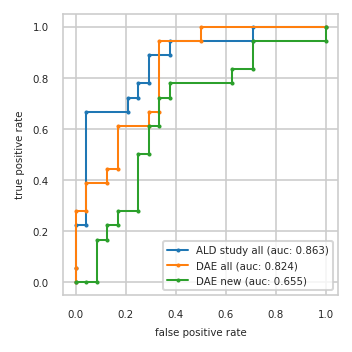

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.222   0.000 0.278   0.083 0.000
3          0.042 0.222   0.042 0.278   0.083 0.167
4          0.042 0.667   0.042 0.389   0.125 0.167
5          0.208 0.667   0.125 0.389   0.125 0.222
6          0.208 0.722   0.125 0.444   0.167 0.222
7          0.250 0.722   0.167 0.444   0.167 0.278
8          0.250 0.778   0.167 0.611   0.250 0.278
9          0.292 0.778   0.292 0.611   0.250 0.500
10         0.292 0.889   0.292 0.667   0.292 0.500
11         0.375 0.889   0.333 0.667   0.292 0.611
12         0.375 0.944   0.333 0.944   0.333 0.611
13         0.708 0.944   0.500 0.944   0.333 0.722
14         0.708 1.000   0.500 1.000   0.375 0.722
15         1.000 1.000   1.000 1.000   0.375 0.778
16           NaN   NaN     NaN   NaN   0.625 0.778
17           NaN   NaN     NaN   NaN   0.625 0.833
18           NaN   NaN     NaN   NaN   0.708 0.833
19           NaN   NaN     NaN   NaN   0.708 0.944
20           NaN   NaN     NaN   NaN   1.000 0.944
21           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YXX1,P04040,Q9UMX0;Q9UMX0-2;Q9UMX0-4
2,O75173;O75173-2;Q5VTW1,P02741,A0A0C4DGV8;Q13214;Q13214-2
3,P61981,P08670,None
4,P14174,Q9Y2T3;Q9Y2T3-3,None
5,P04075,Q14894,None
6,C9JF17;P05090,P63104,None
7,P00338;P00338-3,P04075,None
8,Q6EMK4,P14174,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


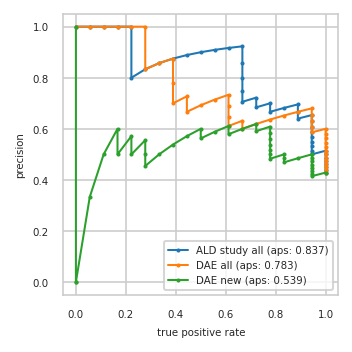

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.654 0.944     0.654 0.944     0.538 0.778
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.667 0.778     0.619 0.722     0.619 0.722
22         0.700 0.778     0.600 0.667     0.600 0.667
23         0.684 0.722     0.632 0.667     0.579 0.611
24         0.722 0.722     0.611 0.611     0.611 0.611
25         0.706 0.667     0.647 0.611     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.923 0.667     0.692 0.500     0.538 0.389
30         0.917 0.611     0.667 0.444     0.500 0.333
31         0.909 0.556     0.727 0.444     0.455 0.278
32         0.900 0.500     0.700 0.389     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


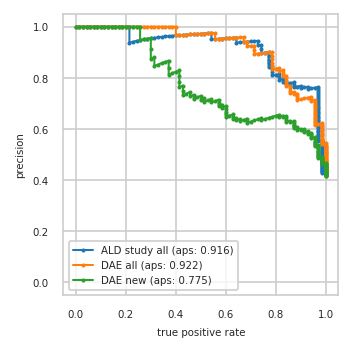

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


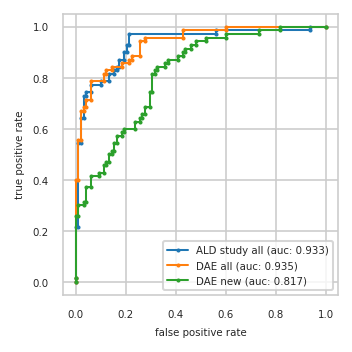

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}